In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

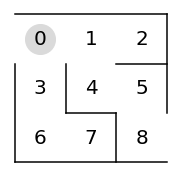

In [2]:
# 게임의 전체 크기
fig = plt.figure( figsize=(3,3) )

# 외곽 벽 그리기
# 수평선 2개
plt.plot( [0, 3],[ 3, 3], color='k') # 맨위 수평선
plt.plot( [0, 3],[ 0, 0], color='k') # 맨아래 수평선
plt.plot( [0, 0],[ 0, 2], color='k') # 왼쪽 수직선 -> 입구표시
plt.plot( [3, 3],[ 1, 3], color='k') # 오른족 수직선

# 내부 미로
plt.plot( [1, 1],[1 , 2], color='k')
plt.plot( [2, 3],[2 , 2], color='k')
plt.plot( [1, 2],[1 , 1], color='k')
plt.plot( [2, 2],[0 , 1], color='k')

# 각 포인트 위치 정보 표시 -> 상태
# 0,1,2 ~ 8까지 위치 정보 표시
'''
0 1 2
3 4 5
6 7 8
'''
for x in range(3):
  for y in range(3):
    plt.text( x + 0.5, 3 - y - 0.5, str(x+3*y), size=20, ha='center', va='center' )

# 에이전트 표시 -> 시작위치 0번(0,0)에 위치
mouse = plt.plot( 0 + 0.5, 3 - 0 - 0.5, marker='o', markersize=30, color='#dadada' )


# 눈금정리
plt.tick_params(bottom=False, left=False,          # - 표시 제거
                labelbottom=False, labelleft=False # 수치값 제거
                )

# 차트 박스 제거
plt.box( False )

# 출력
plt.show()

In [3]:
# 게임이 시작하면 에이전트의 초기 위치
AGENT_FIRST_STATE = 0
# 에이전트 위치가 AGENT_LAST_STATE 와 같다면 게임 종료
AGENT_LAST_STATE  = 8

In [4]:
theta_zero = np.array( [
  # 상, 우, 하, 좌
  [ np.nan, 1, 1, np.nan], #0
  [ np.nan, 1, 1, 1], #1
  [ np.nan, np.nan, np.nan, 1], #2
  [ 1, np.nan, 1, np.nan], #3
  [ 1, 1, np.nan, np.nan], #4
  [ np.nan, np.nan, 1, 1], #5
  [ 1, 1, np.nan, np.nan], #6
  [ np.nan, np.nan, np.nan, 1], #7
] )

theta_zero

array([[nan,  1.,  1., nan],
       [nan,  1.,  1.,  1.],
       [nan, nan, nan,  1.],
       [ 1., nan,  1., nan],
       [ 1.,  1., nan, nan],
       [nan, nan,  1.,  1.],
       [ 1.,  1., nan, nan],
       [nan, nan, nan,  1.]])

In [5]:
# 직접 구현하는 활성화 함수 -> 확률로 계산해서 표현한다
def mySoftmax( theta ):
  # 결과를 담는 그릇
  output = np.zeros_like( theta )

  # 데이터가 큰수가 존재하고, 복잡한 범위를 가진 요소로 구성되어 있다면
  # 지수함수로 일괄처리해서 진행
  theta = np.exp( theta )

  for i in range( theta.shape[0] ):
    # 한줄씩 평균을 계산해서 대체
    output[i] = theta[i] / np.nansum(theta[i])
  
  # nan -> 0 처리
  return np.nan_to_num(output)

policy = mySoftmax(theta_zero)
policy.shape, policy

((8, 4), array([[0.        , 0.5       , 0.5       , 0.        ],
        [0.        , 0.33333333, 0.33333333, 0.33333333],
        [0.        , 0.        , 0.        , 1.        ],
        [0.5       , 0.        , 0.5       , 0.        ],
        [0.5       , 0.5       , 0.        , 0.        ],
        [0.        , 0.        , 0.5       , 0.5       ],
        [0.5       , 0.5       , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 1.        ]]))

In [6]:
# 행동에 따른 다음 상태값 정보(포지션) 획득
def getNextState( curState, nextAction ):
  '''
    curState   : 현재 상태
    nextAction : 다음 행동
  '''
  if   nextAction == 0: # 위로 이동
    return curState - 3
  elif nextAction == 1: # 오른쪽 이동
    return curState + 1
  elif nextAction == 2: # 밑으로 이동
    return curState + 3
  elif nextAction == 3: # 왼쪽 이동
    return curState - 1

In [7]:
x, y = theta_zero.shape
Q    = np.random.rand( x, y ) * theta_zero * 0.01
Q

array([[       nan, 0.00051245, 0.0093291 ,        nan],
       [       nan, 0.00325322, 0.00574301, 0.00056701],
       [       nan,        nan,        nan, 0.00406279],
       [0.00127406,        nan, 0.00373417,        nan],
       [0.00596914, 0.00738495,        nan,        nan],
       [       nan,        nan, 0.00395818, 0.00104168],
       [0.00888211, 0.00586321,        nan,        nan],
       [       nan,        nan,        nan, 0.00353707]])

In [8]:
# 특정 상태에서 특정 행동을 취하는 함수 새로 구성
# 앱실론를 개입하여 적용
def getAction( epsilon, policy, state, Q ):
  if epsilon > np.random.rand(): # epsilon값이 만약 0.1이면 10% 확률로 
    # 정책 경사법에서 사용한 선택방법을 활용하여 액션 결정
    # 랜덤 행동(확률기반)
    return np.random.choice([0,1,2,3], p=policy[state])
  else:
    # 상태값이 state일때 Q함수내에서 최대값을 가진 인덱스 선택
    # 행동가치함수(Q함수 활용)
    # nan을 제거한 수치들중에서 최대값의 인덱스
    return np.nanargmax( Q[state] )

In [9]:
def sarsa( Q, s, a, r, s_next, a_next ):      # Q함수가 갱신
  '''
    Q : 행동가치함수, 갱신의 대상, 정책기준
    s : 에이전트의 현재 상태값(위치값)
    s_next : 에이전트의 다음 상태값
    a : 현재 상태 행동
    a_next : 다음 상태 행동
    r : 즉시 보상
  '''
  eta   = 0.1 # 학습률 고정, TD오차의 10%만 행동가치함수 갱신에 관여하겠다
  gamma = 0.9 # 시간 할인율  -> 90% 만 적용(미래가치에) 
  # 에이전트의 위치가 마지막(골인)이다
  if s_next == AGENT_LAST_STATE:
    #Q[ s, a ] = Q[ s, a ] + eta * ( r + gamma*0 - Q[ s, a ] )
    Q[ s, a ] = Q[ s, a ] + eta * ( r - Q[ s, a ] )
    pass
  else: #일반적인 모든 위치
    Q[ s, a ] = Q[ s, a ] + eta * ( r + gamma*Q[ s_next, a_next ] - Q[ s, a ] )
    pass
  return Q

In [10]:
def q_learning( Q, s, a, r, s_next, a_next ): # Q함수가 갱신
  '''
    Q : 행동가치함수, 갱신의 대상, 정책기준
    s : 에이전트의 현재 상태값(위치값)
    s_next : 에이전트의 다음 상태값
    a : 현재 상태 행동
    a_next : 다음 상태 행동
    r : 즉시 보상
  '''
  eta   = 0.1 # 학습률 고정, TD오차의 10%만 행동가치함수 갱신에 관여하겠다
  gamma = 0.9 # 시간 할인율  -> 90% 만 적용(미래가치에) 
  # 에이전트의 위치가 마지막(골인)이다
  if s_next == AGENT_LAST_STATE:
    Q[ s, a ] = Q[ s, a ] + eta * ( r - Q[ s, a ] )
    pass
  else: #일반적인 모든 위치
    # 어떤 행동을 다음번 스텝에서 취해도 관계없다. 오직 값이 높은 행동만 선택
    # 이것 때문에 수렴도 빠르지만 구소적일수 있다 
    # nanmax() -> nan 빼고 값들 중에 최대값 획득
    Q[ s, a ] = Q[ s, a ] + eta * ( r + gamma*np.nanmax( Q[ s_next, : ] ) - Q[ s, a ] )
    pass

  return Q

In [11]:
def game_play( epsilon, Q1, policy ):
  # 초기 상태
  s       = AGENT_FIRST_STATE
  # 이동 로그
  act_his = [ [ s, np.nan ] ]  
  # 초기 다음 스텝 행동
  a_next  = getAction( epsilon, policy, s, Q1 )  
  # 반복 작업 -> 에이전트가 8번 위치에 도착할때까지
  while True:
    # 1. 다음 행동을 현재 행동으로 변경
    a = a_next    
    # 2. 현재 상태에서 취할 행동으로 인한 다음 상태값 획득
    s_next = getNextState( s, a )
    #print( s, a, s_next  )
    # 3. 로그 한개 완성 -> 값 수정 : np.nan => 행동값으로 대체
    act_his[-1][-1] = a    
    # 4. 새로운 로그 추가
    act_his.append( [ s_next, np.nan ] )
    # 5. 가치 계산을 위한 보상체크
    if AGENT_LAST_STATE == s_next:
      r = 1           # 다음 상태가 골인 지점이면 즉시보상이 1 제공
      a_next = np.nan #  다음 행동을 없다 (게임종료)
    else:
      r      = 0      # 이외의 상태는 전부 즉시보상이 0
      a_next = getAction( epsilon, policy, s_next, Q1 )
    
    # 6. 행동가치함수 갱신 => Q 갱신 => sarsa, q_learnning
    #    1회 행동 => 해당 포지션에 대한 q함수 갱신    
    #Q1 = sarsa( Q1, s, a, r, s_next, a_next )   
    Q1 = q_learning( Q, s, a, r, s_next, a_next )
    
    # 에이전트의 다음 상태값이 최종위치(8)이면 종료
    if AGENT_LAST_STATE == s_next:
      break
    else:
      # 에이전트의 다음 상태값이 현재 상태값으로 치환
      s = s_next

  return act_his, Q1

In [12]:
x, y = theta_zero.shape
Q    = np.random.rand( x, y ) * theta_zero * 0.01
Q

array([[       nan, 0.00697983, 0.0033506 ,        nan],
       [       nan, 0.00157739, 0.00315892, 0.00109172],
       [       nan,        nan,        nan, 0.00612643],
       [0.00439977,        nan, 0.00137643,        nan],
       [0.00356837, 0.00362323,        nan,        nan],
       [       nan,        nan, 0.00355995, 0.0032448 ],
       [0.0058517 , 0.00323553,        nan,        nan],
       [       nan,        nan,        nan, 0.00734546]])

In [13]:
policy

array([[0.        , 0.5       , 0.5       , 0.        ],
       [0.        , 0.33333333, 0.33333333, 0.33333333],
       [0.        , 0.        , 0.        , 1.        ],
       [0.5       , 0.        , 0.5       , 0.        ],
       [0.5       , 0.5       , 0.        , 0.        ],
       [0.        , 0.        , 0.5       , 0.5       ],
       [0.5       , 0.5       , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 1.        ]])

In [14]:

# 시뮬레이션
epsilon = 0.5 # 50 확률로 램덤으로 선택됨 -> 계속 50%씩 수치를 줄이겟다

print( Q )
for epi in range( 10 ): # 10회만 게임 진행
  # 1. 에피소드 진행 : 에이전트 이동 로그,  갱신된 Q함수가 리턴
  act_his, Q = game_play( epsilon, Q, policy )
  # 2. 로그
  #print( '에피소드 {0:2} 에이전트 이동수 {1:3} 엡신론 {2}'.format(epi+1, len(act_his), epsilon) )
  # 3. 엡실론 값을 계속 에피소드가 전개 될때마다 50% 감소
  epsilon /= 2

Q

[[       nan 0.00697983 0.0033506         nan]
 [       nan 0.00157739 0.00315892 0.00109172]
 [       nan        nan        nan 0.00612643]
 [0.00439977        nan 0.00137643        nan]
 [0.00356837 0.00362323        nan        nan]
 [       nan        nan 0.00355995 0.0032448 ]
 [0.0058517  0.00323553        nan        nan]
 [       nan        nan        nan 0.00734546]]


array([[       nan, 0.01358032, 0.0033506 ,        nan],
       [       nan, 0.00197103, 0.05977794, 0.00109172],
       [       nan,        nan,        nan, 0.00579809],
       [0.00439977,        nan, 0.00137643,        nan],
       [0.00356837, 0.24001558,        nan,        nan],
       [       nan,        nan, 0.65256284, 0.0032448 ],
       [0.0058517 , 0.00323553,        nan,        nan],
       [       nan,        nan,        nan, 0.00734546]])

In [15]:
'''
sarsa 로그
에피소드  1 에이전트 이동수  15 엡신론 0.5
에피소드  2 에이전트 이동수  21 엡신론 0.25
에피소드  3 에이전트 이동수  25 엡신론 0.125
에피소드  4 에이전트 이동수   5 엡신론 0.0625
에피소드  5 에이전트 이동수   5 엡신론 0.03125
에피소드  6 에이전트 이동수   5 엡신론 0.015625
에피소드  7 에이전트 이동수   5 엡신론 0.0078125
에피소드  8 에이전트 이동수   5 엡신론 0.00390625
에피소드  9 에이전트 이동수   5 엡신론 0.001953125
에피소드 10 에이전트 이동수   5 엡신론 0.0009765625

Q Learning 로그
에피소드  1 에이전트 이동수  21 엡신론 0.5
에피소드  2 에이전트 이동수  81 엡신론 0.25
에피소드  3 에이전트 이동수  21 엡신론 0.125
에피소드  4 에이전트 이동수   5 엡신론 0.0625
에피소드  5 에이전트 이동수   5 엡신론 0.03125
에피소드  6 에이전트 이동수   5 엡신론 0.015625
에피소드  7 에이전트 이동수   5 엡신론 0.0078125
에피소드  8 에이전트 이동수   5 엡신론 0.00390625
에피소드  9 에이전트 이동수   5 엡신론 0.001953125
에피소드 10 에이전트 이동수   5 엡신론 0.0009765625
'''

'\nsarsa 로그\n에피소드  1 에이전트 이동수  15 엡신론 0.5\n에피소드  2 에이전트 이동수  21 엡신론 0.25\n에피소드  3 에이전트 이동수  25 엡신론 0.125\n에피소드  4 에이전트 이동수   5 엡신론 0.0625\n에피소드  5 에이전트 이동수   5 엡신론 0.03125\n에피소드  6 에이전트 이동수   5 엡신론 0.015625\n에피소드  7 에이전트 이동수   5 엡신론 0.0078125\n에피소드  8 에이전트 이동수   5 엡신론 0.00390625\n에피소드  9 에이전트 이동수   5 엡신론 0.001953125\n에피소드 10 에이전트 이동수   5 엡신론 0.0009765625\n\nQ Learning 로그\n에피소드  1 에이전트 이동수  21 엡신론 0.5\n에피소드  2 에이전트 이동수  81 엡신론 0.25\n에피소드  3 에이전트 이동수  21 엡신론 0.125\n에피소드  4 에이전트 이동수   5 엡신론 0.0625\n에피소드  5 에이전트 이동수   5 엡신론 0.03125\n에피소드  6 에이전트 이동수   5 엡신론 0.015625\n에피소드  7 에이전트 이동수   5 엡신론 0.0078125\n에피소드  8 에이전트 이동수   5 엡신론 0.00390625\n에피소드  9 에이전트 이동수   5 엡신론 0.001953125\n에피소드 10 에이전트 이동수   5 엡신론 0.0009765625\n'

# 결론

- 게임이 복잡해 질수록 Q 함수도 같이 커지고, 이를 처리하는 연산량도 같이 증가 문제 => 비효율적이 된다
- 복잡한 문제는 딥러닝을 활용하여 처리한다
  - DQN은 딥러닝 배우고 나서 진입, CNN 학습 이후 다시 체크